In [1]:
import pandas as pd
import numpy as np

import tubesml as tml

from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

import lightgbm as lgb
import xgboost as xgb

from source import utility as ut
from source import transform as tr
from source.train import train_model
from source.report import plot_regression_predictions, plot_learning_curve

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings

pd.set_option('max_columns', 100)

In [2]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
subs = pd.read_csv('data/sample_submission.csv')

In [3]:
train_set, test_set = ut.make_test(df_train, 0.25, random_state=516, strat_feat='cat9')

train_set.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
217278,362397,A,A,A,A,B,D,A,E,G,F,0.992968,0.062644,0.137455,0.771707,0.494401,0.889793,0.477072,0.777355,0.894772,0.832945,0.528586,0.712178,0.876089,0.594609,6.405349
168076,280139,A,A,A,A,B,A,A,E,A,F,0.706340,0.297613,0.574490,0.685358,0.280016,0.980636,0.875379,0.650188,0.210627,0.543731,0.551951,0.821223,0.898238,0.422612,7.616449
85899,142986,B,B,A,C,B,D,A,E,G,M,0.735604,0.770009,0.350257,0.561776,0.266121,0.918674,0.828429,0.345399,0.901242,0.759109,0.726503,0.637654,0.901267,0.729128,7.678379
66230,110149,A,B,A,C,B,D,A,E,G,I,0.855760,0.617747,0.145037,0.218510,0.677832,0.520412,0.304368,0.676240,0.862597,0.153856,0.177909,0.848022,0.311321,0.766169,6.642889
202344,337370,A,A,A,C,B,B,A,E,C,F,0.397990,0.069838,0.452991,0.174816,0.775703,0.305720,0.349109,0.702810,0.304682,0.441488,0.240995,0.381703,0.302658,0.719237,8.427913


In [4]:
del train_set['id']
del test_set['id']

y = train_set['target'].copy()
del train_set['target']
y_test = test_set['target'].copy()
del test_set['target']

In [5]:
numeric_pipe = Pipeline([('fs', tml.DtypeSel('numeric'))])


cat_pipe = Pipeline([('fs', tml.DtypeSel('category')),
                     ('tarenc', tr.TargetEncoder(to_encode=[f'cat{c}' for c in range(3,10)])),
                     ('dummies', tml.Dummify(match_cols=True, drop_first=True))])


processing_pipe = tml.FeatureUnionDf(transformer_list=[('cat_pipe', cat_pipe),
                                                 ('num_pipe', numeric_pipe)])


full_pipe = Pipeline([('processing', processing_pipe), 
                      ('scaler', tml.DfScaler())])

In [6]:
folds = KFold(10, shuffle=True, random_state=541)

In [7]:
mod = lgb.LGBMRegressor(n_estimators=2000, n_jobs=5)

oof, pred, rep_res = train_model(train_set, test_set, y, full_pipe, mod, folds, early_stopping=100, verbose=False, pdp=['cont0', 'cont8', 'con9'])

In [8]:
rep_res['n_iterations']

[231, 342, 299, 192, 162, 300, 266, 304, 235, 149]

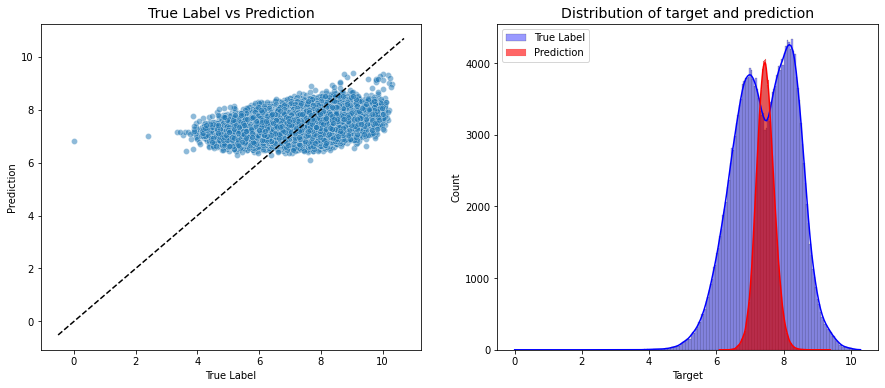

In [9]:
plot_regression_predictions(train_set, y, oof)

<ipython-input-8-d9e1a2324429>:30: UserWarning: cont1 has more than 5 unique values, hue will be ignored
  warnings.warn(f'{hue} has more than 5 unique values, hue will be ignored', UserWarning)


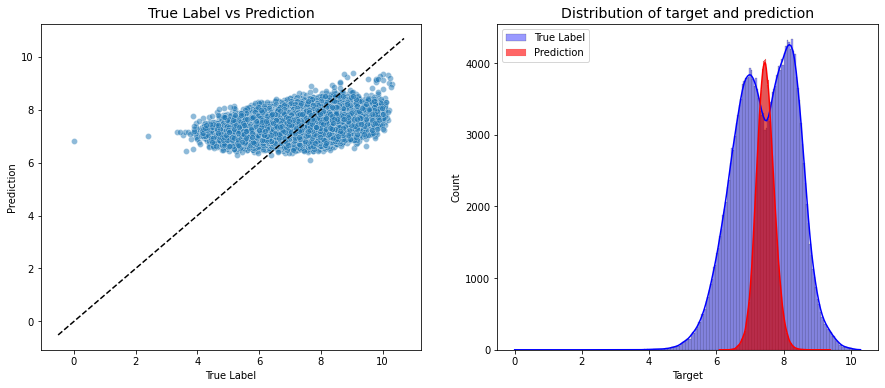

In [10]:
plot_regression_predictions(train_set, y, oof, 'cont1')

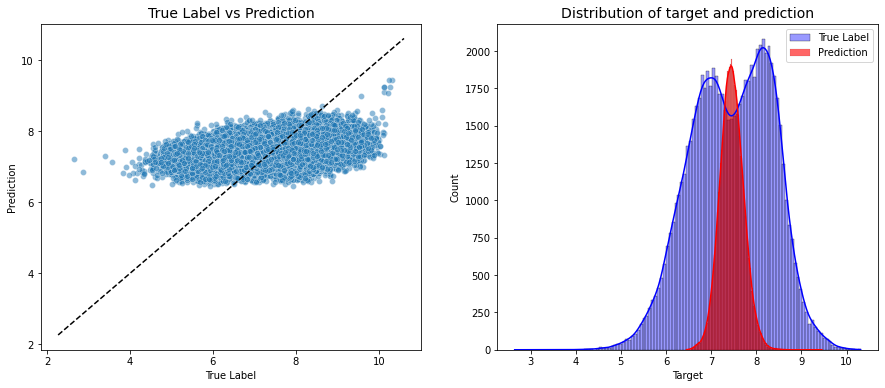

In [12]:
plot_regression_predictions(test_set, y_test, pred)

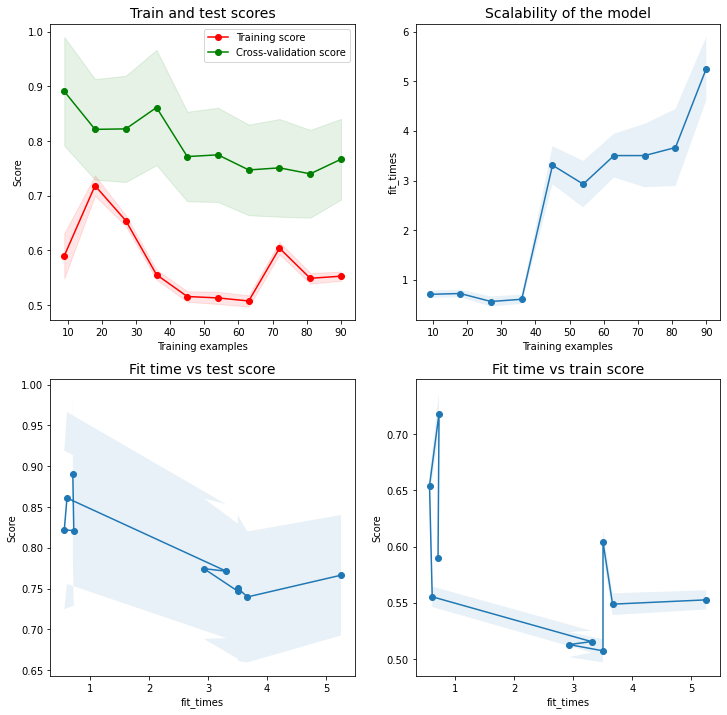

In [11]:
mod_pipe = Pipeline([('pipe', full_pipe), 
                     ('lgb', lgb.LGBMRegressor(n_estimators=100, n_jobs=5))])

plot_learning_curve(mod_pipe, train_set[:100], y[:100], scoring='neg_mean_squared_error', ylim=None, cv=folds,
                        n_jobs=5, train_sizes=np.linspace(.1, 1.0, 10), title=None)

In [10]:
mod = xgb.XGBRegressor(n_estimators=2000, n_jobs=5)

oof, pred, rep_res = train_model(train_set, test_set, y, full_pipe, mod, folds, early_stopping=100, verbose=False, pdp=['cat6', 'cat9', 'cont8'])

/home/lucabasa/Git/kaggle_competitions/tabular_playground/tabplay/lib/python3.8/site-packages/sklearn/inspection/_partial_dependence.py:505: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(
/home/lucabasa/Git/kaggle_competitions/tabular_playground/tabplay/lib/python3.8/site-packages/sklearn/inspection/_partial_dependence.py:505: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(
/home/lucabasa/Git/kaggle_competitions/tabular_playground/tabplay/lib/python3.8/site-packages/sklearn/inspection/_partial_dependence.py:505: FutureWarning: A Bunch will be returned in place of 'predictions' from vers

In [14]:
pdps = rep_res['pdp']

In [23]:
pdps['x'] = round(pdps['x'], 1)
pdps.groupby(['feat', 'x'])['y'].agg(['mean', 'std'])

mean       std
feat  x                       
cat6  -0.3  7.444042       NaN
      -0.2  7.453298  0.001773
      -0.1  7.455311  0.002883
       0.0  7.457687       NaN
       0.1  7.475112  0.018572
...              ...       ...
cont8  1.6  7.551623  0.017726
       1.7  7.540168  0.022779
       1.8  7.423705  0.018098
       1.9  7.474647  0.006249
       2.0  7.534603  0.021341

[82 rows x 2 columns]